In [1]:
import pandas as pd
import numpy as np

import glob
import re

from matplotlib import pyplot as plt
import seaborn as sns
import altair as alt
sns.set()

glob.glob('*.csv')

['covid_data.csv',
 'a98d1d87-f256-432c-8124-5879c4053c51_Series - Metadata.csv',
 'covid_data_20211031.csv',
 'worldbank_demographic_data.csv']

# 1. COVID data

#### - Variables analyzed: cumulative cases per 100k population and deaths per 100k population for each country as of 2021-10-31.
#### - Source: data repository for the 2019 Novel Coronavirus Visual Dashboard  operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). The data include the location and number of confirmed COVID-19 cases, deaths, and recoveries for all affected countries, aggregated at the appropriate province/state. Available at: https://console.cloud.google.com/marketplace/product/johnshopkins/covid19_jhu_global_case?project=gcloud-ed

In [2]:
COVID_INPUT = 'covid_data_20211031.csv'
DEMOG_INPUT = 'worldbank_demographic_data.csv'

In [3]:
covid_df = pd.read_csv(COVID_INPUT)
covid_df.head()

,country_name,cases,deaths
0,Afghanistan,156250,7280
1,Albania,185300,2924
2,Algeria,206452,5920
3,Andorra,15516,130
4,Angola,64433,1710


In [4]:
def clean_country_name(n):
    return '_'.join(
        n.strip().split(' ')
    ).lower()

def clean_covid_data(_df):
    df = _df.copy(deep=True)
    
    df['country_name'] = df['country_name'].apply(clean_country_name)
    
    return df.dropna()

In [5]:
# Format country name
covid_df = clean_covid_data(_df=covid_df)
covid_df.head()

,country_name,cases,deaths
0,afghanistan,156250,7280
1,albania,185300,2924
2,algeria,206452,5920
3,andorra,15516,130
4,angola,64433,1710


## 2. Demographic data

#### - Variables analyzed: GDP per capita, % of population with access to sanitation, health investment per capita, total population and total urban population for each country.

#### - Source: World Bank DataBank - World Development Indicators. Available at: https://databank.worldbank.org/source/world-development-indicators#

In [6]:
demog_df = pd.read_csv(DEMOG_INPUT)
demog_df.head()

,Country Name,Country Code,Series Name,Series Code,2019 [YR2019]
0,Afghanistan,AFG,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,31.802
1,Afghanistan,AFG,Current health expenditure per capita (current...,SH.XPD.CHEX.PC.CD,65.80603027
2,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,18799450742.7823
3,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,494.179349886029
4,Afghanistan,AFG,"Government expenditure on education, total (% ...",SE.XPD.TOTL.GD.ZS,3.21377992630005


In [7]:
############################################################
# MAPPINGS FROM SERIES CODE TO SERIES NAME, DICT AND TABLE #
############################################################

# Dict
SERIES_MAP = {
    series['Series Code']: series['Series Name']
    for series in demog_df[
        ['Series Name', 'Series Code']
    ]\
    .drop_duplicates()\
    .dropna()\
    .to_dict(orient='records')
}

# Table
SERIES_TABLE = demog_df[
    ['Series Name', 'Series Code']
].drop_duplicates().dropna().sort_values(
    by='Series Code'
).reset_index(
    drop=True
)

In [8]:

def clean_demog_data(_df):

    df = _df.copy(deep=True)
    # Get statistic for each country
    df = df[
        ~df['2019 [YR2019]'].apply(lambda x: x=='..' or pd.isna(x))
    ][[
        'Country Name',
        'Series Name',
        'Series Code',
        '2019 [YR2019]'
    ]].pivot(
        index='Country Name',
        columns='Series Code',
        values='2019 [YR2019]'
    ).reset_index().rename(
        columns={'Country Name':'country_name'}
    )
    df.columns.name = None

    # Remove statistics with lots of NaN values
    df = df[
        [col for col in df.columns\
             if col not in [
                'SI.POV.GINI',
                'SE.ADT.LITR.ZS',
                'SE.XPD.TOTL.GD.ZS',
                'EN.URB.MCTY.TL.ZS',
                'EN.POP.DNST',
                'FP.CPI.TOTL',
                'SP.DYN.CBRT.IN',
                'SH.XPD.CHEX.GD.ZS',
                'NY.GDP.MKTP.CD'
            ]
        ]
    ]
    df = df.dropna()

    # Format country name
    df['country_name'] = df['country_name'].apply(clean_country_name)
    
    for col in [c for c in df.columns if c != 'country_name']:
        df[col] = df[col].astype(float)
    
    return df.reset_index(drop=True)

In [9]:
# Transform table to having each row a country and each column a metric relative to a country
demog_df = clean_demog_data(_df=demog_df)
demog_df.head()

,country_name,NY.GDP.PCAP.CD,SH.STA.SMSS.ZS,SH.XPD.CHEX.PC.CD,SP.POP.TOTL,SP.URB.TOTL.IN.ZS
0,africa_western_and_central,1777.918672,24.231488,61.338476,446911598.0,47.242853
1,algeria,3989.668276,17.839063,248.205872,43053054.0,73.189000
2,andorra,40897.330873,100.000004,2744.194336,77146.0,87.984000
3,arab_world,6489.043216,49.538868,381.575981,427870273.0,59.201646
4,armenia,4604.646324,67.762796,523.999084,2957728.0,63.219000


# 3. Join COVID and Demographic data, perform PCA

In [10]:
# JOIN DEMOGRAPHIC DATA WITH COVID DATA
joined = pd.merge(
    covid_df,
    demog_df,
    on='country_name',
    how='inner'
)
joined['cases_per_100k_pop'] = 1E5*joined['cases']/joined['SP.POP.TOTL']
joined['deaths_per_100k_pop'] = 1E5*joined['deaths']/joined['SP.POP.TOTL']
joined = joined.drop(columns=['cases', 'deaths'])
joined

,country_name,NY.GDP.PCAP.CD,SH.STA.SMSS.ZS,SH.XPD.CHEX.PC.CD,SP.POP.TOTL,SP.URB.TOTL.IN.ZS,cases_per_100k_pop,deaths_per_100k_pop
0,algeria,3989.668276,17.839063,248.205872,43053054.0,73.189,479.529280,13.750476
1,andorra,40897.330873,100.000004,2744.194336,77146.0,87.984,20112.513935,168.511653
2,armenia,4604.646324,67.762796,523.999084,2957728.0,63.219,10424.420366,213.948003
3,australia,54875.285956,73.292582,5427.462402,25365745.0,86.124,678.198097,6.871472
4,austria,50114.401110,99.640766,5242.183105,8879920.0,58.515,9357.978450,127.895296
...,...,...,...,...,...,...,...,...
94,turkey,9121.515167,78.062272,396.466827,83429607.0,75.630,9628.426033,84.635422
95,ukraine,3661.456204,71.977338,248.133484,44386203.0,69.473,6889.771581,162.377034
96,united_arab_emirates,42701.443045,99.147700,1842.694458,9770526.0,86.789,7572.826683,21.861668
97,united_kingdom,43070.498360,98.081537,4312.889160,66836327.0,83.652,13616.011544,211.045409


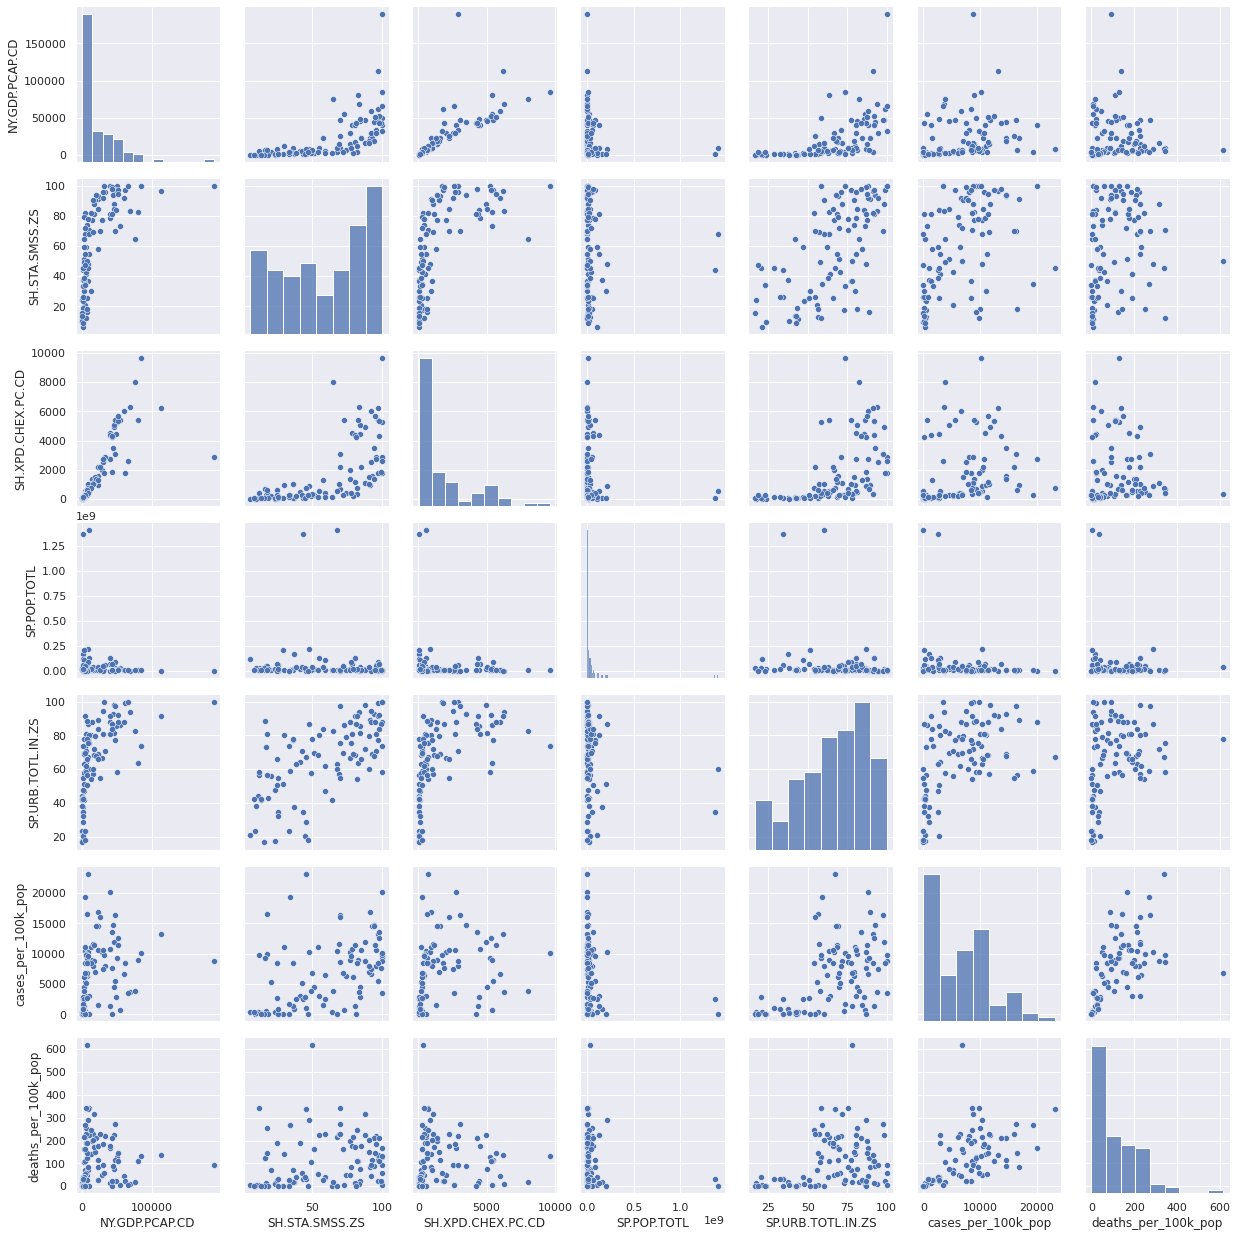

In [11]:
sns.pairplot(joined)

In [22]:
# Get Z-scores for X
X=(joined-joined.mean())/np.sqrt(joined.var())

# Get eigenvalues for correlation matrix of X
pcs_vars, pcs = np.linalg.eigh(
    a=pd.DataFrame(X).corr()
)

# Transform eigenvectors from cols to rows
pcs = pcs.T

# Sort eigenvectors by eigenvalue size (desc)
pcs_vars, pcs = zip(
    *sorted(
        zip(pcs_vars, pcs),
        reverse=True
    )
)
pcs = np.array(pcs)

# Columns for printing
PRINT_COLS = [
    'pib_per_capita',
    'perc_acesso_saneamento',
    'invest_saude_per_capita',
    'populacao_total',
    'populacao_urbana_total',
    'casos_por_100k_habit',
    'mortes_por_100k_habit'
]

print('-'*100)
print('Total variables in PCA analysis: {}'.format(X.corr().shape[0]))
print('-'*100)

----------------------------------------------------------------------------------------------------
Total variables in PCA analysis: 7
----------------------------------------------------------------------------------------------------


In [13]:
print('-'*100)
print('PCS VARIANCES (EIGENVALUES):\n{}'.format(
        pcs_vars
    )
)
print('-'*100)

----------------------------------------------------------------------------------------------------
PCS VARIANCES (EIGENVALUES):
(3.323539426788753, 1.4477523922846762, 0.9624008884184018, 0.4242773606110865, 0.3342049468605675, 0.29712546744175694, 0.21069951759476005)
----------------------------------------------------------------------------------------------------


In [14]:
print('-'*100)
print('CUMULATIVE VARIANCE EXPLAINED:\n{}'.format(
        np.cumsum(pcs_vars)/np.sum(pcs_vars)
    )
)
print('-'*100)

----------------------------------------------------------------------------------------------------
CUMULATIVE VARIANCE EXPLAINED:
[0.47479135 0.68161312 0.81909896 0.87971001 0.92745357 0.96990007
 1.        ]
----------------------------------------------------------------------------------------------------


In [15]:
print('-'*100)
print('PRINCIPAL COMPONENTS:\n{}'.format(pcs))
print('-'*100)

----------------------------------------------------------------------------------------------------
PRINCIPAL COMPONENTS:
[[-0.43789396 -0.46829614 -0.43324991  0.11619838 -0.45269122 -0.36748051
  -0.21856073]
 [ 0.36288282  0.09856229  0.35543604  0.20013018 -0.01976723 -0.48946657
  -0.67249268]
 [ 0.06658761 -0.16180052  0.06430745 -0.96193658 -0.04648447 -0.09506577
  -0.16950206]
 [-0.28004057  0.14750899 -0.43126753 -0.04580532  0.78003894 -0.15321776
  -0.28247502]
 [ 0.14889713 -0.48745217  0.21768721  0.05120908  0.35200341 -0.54127026
   0.52280976]
 [ 0.27821038 -0.68843496 -0.02029397  0.12665404  0.21577093  0.53324603
  -0.3182684 ]
 [ 0.70294875  0.10720807 -0.6693527  -0.01902966 -0.11659703 -0.12466977
   0.1297571 ]]
----------------------------------------------------------------------------------------------------


In [16]:
# First PC
PC_NUMBER=1
pd.DataFrame(
    index=[0],
    data = dict(zip(PRINT_COLS,pcs[PC_NUMBER-1]))
)

,pib_per_capita,perc_acesso_saneamento,invest_saude_per_capita,populacao_total,populacao_urbana_total,casos_por_100k_habit,mortes_por_100k_habit
0,-0.437894,-0.468296,-0.43325,0.116198,-0.452691,-0.367481,-0.218561


In [17]:
# Second PC
PC_NUMBER=2
pd.DataFrame(
    index=[0],
    data = dict(zip(PRINT_COLS,pcs[PC_NUMBER-1]))
)

,pib_per_capita,perc_acesso_saneamento,invest_saude_per_capita,populacao_total,populacao_urbana_total,casos_por_100k_habit,mortes_por_100k_habit
0,0.362883,0.098562,0.355436,0.20013,-0.019767,-0.489467,-0.672493


In [18]:
# Third PC
PC_NUMBER=3
pd.DataFrame(
    index=[0],
    data = dict(zip(PRINT_COLS,pcs[PC_NUMBER-1]))
)

,pib_per_capita,perc_acesso_saneamento,invest_saude_per_capita,populacao_total,populacao_urbana_total,casos_por_100k_habit,mortes_por_100k_habit
0,0.066588,-0.161801,0.064307,-0.961937,-0.046484,-0.095066,-0.169502


In [19]:
# PROJECTION OF X ONTO PC BASIS
X_pc = np.matmul(X.drop(columns='country_name'), pcs.T)
X_pc.columns = ['pc_{}'.format(i+1) for i in range(pcs.shape[1])]

# Add variables for analysis
X_pc['country_name'] = joined['country_name']
X_pc['cases_per_100k_pop'] = joined['cases_per_100k_pop']
X_pc['deaths_per_100k_pop'] = joined['deaths_per_100k_pop']

In [20]:
print('-'*100)
print('FIRST PC:\n{}'.format(
        pd.DataFrame(
            index=[0],
            data = dict(zip(PRINT_COLS,pcs[0]))
        )
    ) 
)
print('-'*100)
print('SECOND PC:\n{}'.format(
        pd.DataFrame(
            index=[0],
            data = dict(zip(PRINT_COLS,pcs[1]))
        )
    ) 
)
print('-'*100)

# Cases per 100k pop
chart = alt.Chart(X_pc).mark_circle(size=60).encode(
    x='pc_1',
    y='pc_2',
    color=alt.Color('cases_per_100k_pop', scale=alt.Scale(scheme='magma')),
    tooltip=['country_name','cases_per_100k_pop']
).properties(
    width=1200,
    height=900
).configure_view(
    strokeWidth=0
)
chart

----------------------------------------------------------------------------------------------------
FIRST PC:
   pib_per_capita  perc_acesso_saneamento  invest_saude_per_capita  \
0       -0.437894               -0.468296                 -0.43325   

   populacao_total  populacao_urbana_total  casos_por_100k_habit  \
0         0.116198               -0.452691             -0.367481   

   mortes_por_100k_habit  
0              -0.218561  
----------------------------------------------------------------------------------------------------
SECOND PC:
   pib_per_capita  perc_acesso_saneamento  invest_saude_per_capita  \
0        0.362883                0.098562                 0.355436   

   populacao_total  populacao_urbana_total  casos_por_100k_habit  \
0          0.20013               -0.019767             -0.489467   

   mortes_por_100k_habit  
0              -0.672493  
----------------------------------------------------------------------------------------------------


alt.Chart(...)

In [21]:
print('-'*100)
print('FIRST PC:\n{}'.format(
        pd.DataFrame(
            index=[0],
            data = dict(zip(PRINT_COLS,pcs[0]))
        )
    ) 
)
print('-'*100)
print('SECOND PC:\n{}'.format(
        pd.DataFrame(
            index=[0],
            data = dict(zip(PRINT_COLS,pcs[1]))
        )
    ) 
)
print('-'*100)

# Deaths per 100k pop
chart = alt.Chart(X_pc).mark_circle(size=60).encode(
    x='pc_1',
    y='pc_2',
    color=alt.Color('deaths_per_100k_pop', scale=alt.Scale(scheme='magma')),
    tooltip=['country_name', 'deaths_per_100k_pop']
).properties(
    width=1200,
    height=900
).configure_view(
    strokeWidth=0
)
chart

----------------------------------------------------------------------------------------------------
FIRST PC:
   pib_per_capita  perc_acesso_saneamento  invest_saude_per_capita  \
0       -0.437894               -0.468296                 -0.43325   

   populacao_total  populacao_urbana_total  casos_por_100k_habit  \
0         0.116198               -0.452691             -0.367481   

   mortes_por_100k_habit  
0              -0.218561  
----------------------------------------------------------------------------------------------------
SECOND PC:
   pib_per_capita  perc_acesso_saneamento  invest_saude_per_capita  \
0        0.362883                0.098562                 0.355436   

   populacao_total  populacao_urbana_total  casos_por_100k_habit  \
0          0.20013               -0.019767             -0.489467   

   mortes_por_100k_habit  
0              -0.672493  
----------------------------------------------------------------------------------------------------


alt.Chart(...)